# 联邦学习-优化

Federated Learning Round 1
Client 1
Epoch [1/20], Loss: 1.3274, Val Loss: 1.2293
Epoch [2/20], Loss: 1.2004, Val Loss: 1.1521
Epoch [3/20], Loss: 1.1267, Val Loss: 1.1021
Epoch [4/20], Loss: 1.0773, Val Loss: 1.0486
Epoch [5/20], Loss: 1.0404, Val Loss: 1.0031
Epoch [6/20], Loss: 0.9849, Val Loss: 0.9680
Epoch [7/20], Loss: 0.9544, Val Loss: 0.9402
Epoch [8/20], Loss: 0.9169, Val Loss: 0.8895
Epoch [9/20], Loss: 0.8736, Val Loss: 0.8594
Epoch [10/20], Loss: 0.8489, Val Loss: 0.8335
Epoch [11/20], Loss: 0.8254, Val Loss: 0.8078
Epoch [12/20], Loss: 0.8072, Val Loss: 0.7876
Epoch [13/20], Loss: 0.7776, Val Loss: 0.7685
Epoch [14/20], Loss: 0.7650, Val Loss: 0.7421
Epoch [15/20], Loss: 0.7389, Val Loss: 0.7456
Epoch [16/20], Loss: 0.7314, Val Loss: 0.7234
Epoch [17/20], Loss: 0.7037, Val Loss: 0.7119
Epoch [18/20], Loss: 0.7190, Val Loss: 0.7101
Epoch [19/20], Loss: 0.6910, Val Loss: 0.6989
Epoch [20/20], Loss: 0.6793, Val Loss: 0.6900
Client 2
Epoch [1/20], Loss: 1.3222, Val Loss: 1.2219

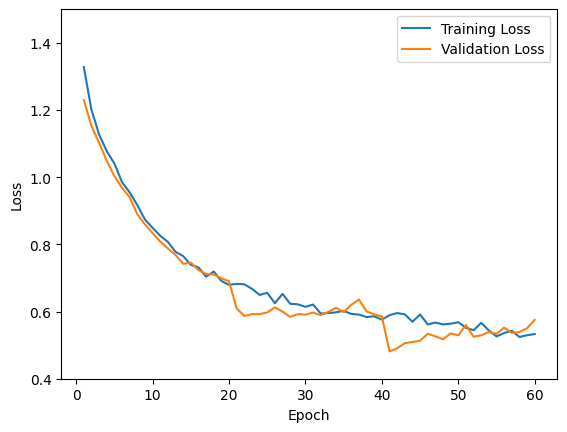

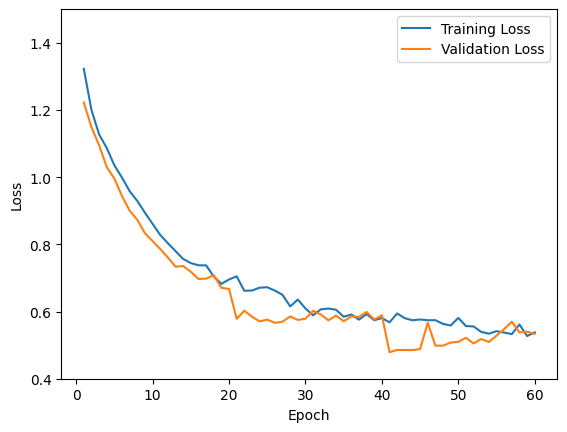

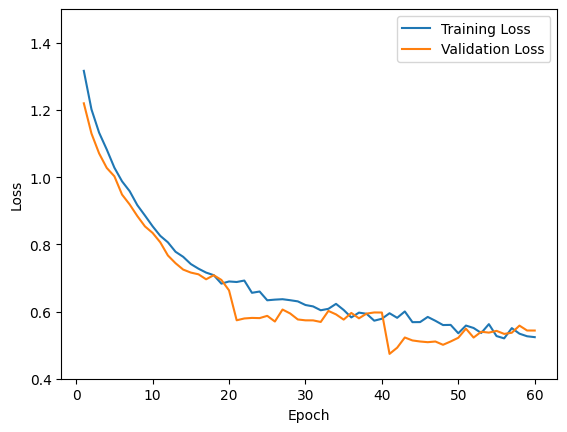

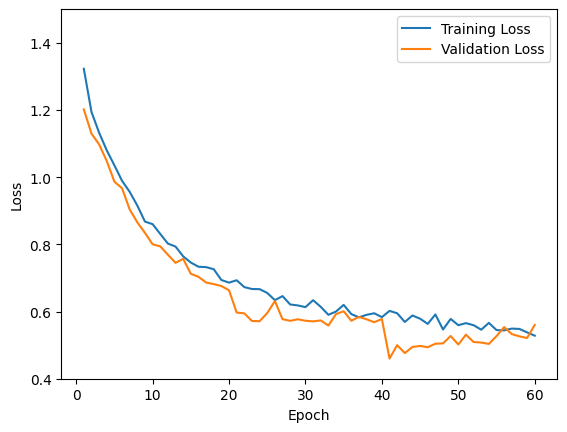

Global Model Accuracy: 0.7350
Global Model Precision: 0.7337
Global Model Recall: 0.7350
Global Model F1 Score: 0.7334


In [1]:
"""
Created by Charles-Deng
870055485@qq.com
Date: 2023/4/2 12:08
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dataset && DataLoader
class HouseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)  # Convert sparse matrix to dense
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# PyTorch
class Net(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.15, l2_reg=0.00):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_prob)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(dropout_prob)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(dropout_prob)

        self.fc5 = nn.Linear(32, output_size)

        self.l2_reg = l2_reg

    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)
        return x

    def l2_regularization(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param, p=2) ** 2
        return self.l2_reg * l2_loss

# def preprocess_data(data):
#     categorical_features = ['zip code', 'city']
#     numerical_features = [col for col in data.columns if col not in categorical_features + ["cost rank"]]

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', StandardScaler(with_mean=False), numerical_features),
#             ('cat', OneHotEncoder(), categorical_features)
#         ])

#     X = preprocessor.fit_transform(data.iloc[:, :-1])
#     y = data["cost rank"].values - 1
#     return X, y

def preprocess_data(data, preprocessor=None):# some improvement
    categorical_features = ['zip code', 'city']
    numerical_features = [col for col in data.columns if col not in categorical_features + ["cost rank"]]

    # Considering two condition, with respect to train and predict part
    if preprocessor is None:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(with_mean=False), numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ])

        # fit the data
        X = preprocessor.fit_transform(data.iloc[:, :-1])
    else:
        X = preprocessor.transform(data.iloc[:, :-1])

    if "cost rank" in data.columns:
        y = data["cost rank"].values - 1
        return X, y, preprocessor
    else:
        return X, preprocessor

# from MLP model
def predict_fold(model, test_loader):
    fold_true_labels = []
    fold_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            fold_true_labels.extend(labels.numpy())
            fold_predictions.extend(predicted.numpy())

    return fold_true_labels, fold_predictions

# from MLP model
def evaluate_fold(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# from MLP model
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs):
    losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels) + model.l2_regularization()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()
        train_loss = running_loss / len(train_loader)
        losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return losses, val_losses

def average_weights(global_model, client_models):
    """
    Calculate the federated average
    """
    global_dict = global_model.state_dict()  # read the trainable weights
    for k in global_dict.keys():
        global_dict[k] = torch.zeros_like(global_dict[k])  # set to 0 for initializing

    for client_model in client_models:
        client_dict = client_model.state_dict()
        for k in global_dict.keys():
            global_dict[k] += client_dict[k]

    for k in global_dict.keys():  # Federate Average
        global_dict[k] = global_dict[k] / len(client_models)

    global_model.load_state_dict(global_dict)  # update

def federated_learning_round(global_model, X, y, client_total_losses, num_clients=4, num_epochs=20):
    """
    Executing one round federated learning.
    """
    # Create several clients
    client_models = [copy.deepcopy(global_model) for _ in range(num_clients)]
    skf = StratifiedKFold(n_splits=num_clients, shuffle=True, random_state=42)
    client_data = [(train_idx, test_idx) for train_idx, test_idx in skf.split(X, y)]

    # 4 clients training seperately
    for client_idx, (train_idx, test_idx) in enumerate(client_data):
        print(f"Client {client_idx + 1}")

        # Load the data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        train_dataset = HouseDataset(X_train, y_train)
        test_dataset = HouseDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Setting hyper parms seperately
        model = client_models[client_idx]
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=32, gamma=0.1)

        # Save the loss history for further plot
        losses, val_losses = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs)
        try:
            client_total_losses[client_idx].append([losses, val_losses])
        except:
            client_total_losses[client_idx] = []
            client_total_losses[client_idx].append([losses, val_losses])

    # After training finished, use federated averaging update the weights.
    average_weights(global_model, client_models)
    return client_total_losses


if __name__ == "__main__":

    data = pd.read_csv("./2.4_Train_Data_New.csv")
    X, y, preprocessor = preprocess_data(data)

    input_size = X.shape[1]
    output_size = len(np.unique(y))
    global_model = Net(input_size, output_size)

    # Split data into global training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    client_total_loss_dict = {}
    num_rounds = 3 # total federated learning rounds
    for round_idx in range(num_rounds):
        print(f"Federated Learning Round {round_idx + 1}")
        client_total_loss_dict = federated_learning_round(global_model, X_train, y_train, client_total_loss_dict,
                                                          num_epochs=20)

    # Evaluate global model on testing set
    test_dataset = HouseDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    global_model.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = global_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.numpy())
            predictions.extend(predicted.numpy())

    # Combine the losses in three rounds and plot together
    for key in client_total_loss_dict:
        train_loss = []
        val_loss = []
        for round in range(0, len(client_total_loss_dict[key])):
            train_loss += client_total_loss_dict[key][round][0]
            val_loss += client_total_loss_dict[key][round][1]
        plt.figure()
        plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
        plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.ylim([0.4, 1.5])
        plt.legend()
        plt.show()

    # Get the evaluation table
    accuracy, precision, recall, f1 = evaluate_fold(true_labels, predictions)
    print(f"Global Model Accuracy: {accuracy:.4f}")
    print(f"Global Model Precision: {precision:.4f}")
    print(f"Global Model Recall: {recall:.4f}")
    print(f"Global Model F1 Score: {f1:.4f}")
#--------------------------------------------------------------------------------------

# Preserve the model and predict the unlabeled data

In [ ]:
"""
"""
# Predict the unlabeled data
"""
# Save the model
torch.save(global_model.state_dict(), 'global_model.pth')

def predict_unlabeled_data(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.numpy())
    return predictions

# Read the unlabeled test data
unlabeled_data = pd.read_csv("2.4_Test_Data_New.csv")

# Use existing preprocessor to process the test data.
X_unlabeled, _, _ = preprocess_data(unlabeled_data, preprocessor)

# data conversion
unlabeled_dataset = HouseDataset(X_unlabeled, np.zeros(X_unlabeled.shape[0]))  # zero padding instead of y input
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)

# Global model predict the data
predicted_labels = predict_unlabeled_data(global_model, unlabeled_loader)

# Adding the prediction to the CSV file
unlabeled_data["cost rank"] = np.array(predicted_labels) + 1
unlabeled_data.to_csv("testresult.csv", index=False)
"""